In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.get_option("display.max_columns")
import seaborn as sns


In [17]:
df = pd.read_csv('../data/clean/deliveries.csv')
df.dtypes

id                        object
route_id                  object
state                      int64
_status                   object
items                     object
total_size                 int64
pickupLat                float64
pickupLng                float64
deliveryLat              float64
deliveryLng              float64
pickup_dt                 object
max_pickup_dt             object
pickup_arrival_dt         object
pickup_effective_dt       object
delivery_dt               object
max_delivery_dt           object
delivery_arrival_dt       object
delivery_effective_dt     object
cost                     float64
final_price              float64
distance                 float64
shipper_id               float64
distance_charged         float64
distance_route           float64
total_package_price      float64
vehicle_capacity         float64
dtype: object

In [6]:
df['pickup_dt'] = pd.to_datetime(df['pickup_dt'])
df['delivery_dt'] = pd.to_datetime(df['delivery_dt'])
df['week_day_pickup'] = df['pickup_dt'].dt.day_name()
df['week_day_delivery'] = df['delivery_dt'].dt.day_name()


In [7]:
pickup_per_day = df.groupby('week_day_pickup')['id'].count().reset_index()
pickup_per_day.columns = ['week_day_pickup', 'pickups_per_day']
pickup_per_day.head()

,week_day_pickup,pickups_per_day
0,Friday,13007
1,Monday,20239
2,Saturday,7291
3,Sunday,2334
4,Thursday,13134


In [8]:
deliveries_per_day = df.groupby('week_day_delivery')['id'].count().reset_index()
deliveries_per_day.columns = ['week_day_delivery', 'deliveries_per_day']
deliveries_per_day.head()

,week_day_delivery,deliveries_per_day
0,Friday,13265
1,Monday,13237
2,Saturday,9435
3,Sunday,4278
4,Thursday,14832


Text(0, 0.5, 'Number of pickups')

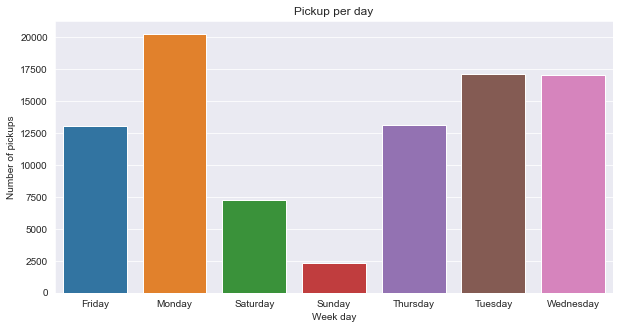

In [9]:
# barplot og week_day_pickup
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='week_day_pickup', y='pickups_per_day', data=pickup_per_day, ax=ax)
ax.set_title('Pickup per day')
ax.set_xlabel('Week day')
ax.set_ylabel('Number of pickups')

Text(0, 0.5, 'Number of deliveries')

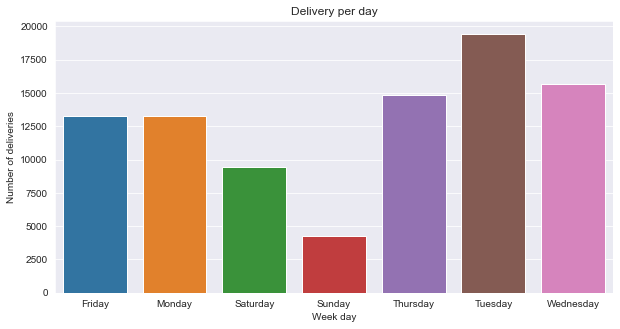

In [10]:
# bar plot of week_day_delivery
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='week_day_delivery', y='deliveries_per_day', data=deliveries_per_day, ax=ax)
ax.set_title('Delivery per day')
ax.set_xlabel('Week day')
ax.set_ylabel('Number of deliveries')


In [11]:
df2 = df.loc[df['pickup_dt'] <= '2022-05-31', ['id', 'pickup_dt', 'delivery_dt']]
df2_activity_pickup = df2.groupby([pd.Grouper(key='pickup_dt', freq='D')])['id'].count().reset_index()
df2_activity_delivery = df2.groupby([pd.Grouper(key='delivery_dt', freq='D')])['id'].count().reset_index()
df2_activity_pickup.columns = ['day', 'pickups_per_day']
df2_activity_delivery.columns = ['day', 'deliveries_per_day']
df_total_activity = pd.merge(df2_activity_pickup, df2_activity_delivery, on='day', how='inner')
df_total_activity['total_activity'] = df_total_activity['pickups_per_day'] + df_total_activity['deliveries_per_day']
## format day to number of calendar day
df_total_activity['day'] = df_total_activity['day'].dt.day

df_total_activity.head()

,day,pickups_per_day,deliveries_per_day,total_activity
0,1,115,106,221
1,2,4351,2759,7110
2,3,3592,4066,7658
3,4,4916,4115,9031
4,5,3825,4300,8125


Text(0, 0.5, 'Activity')

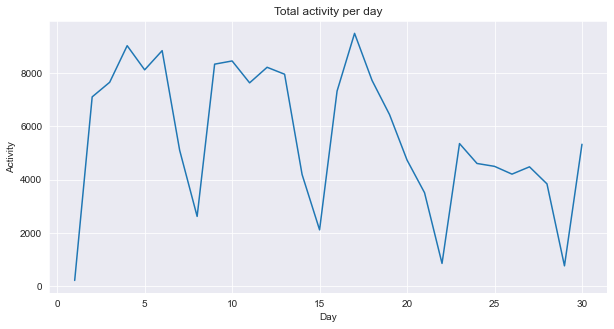

In [12]:
## line plot total deliveries per day
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='day', y='total_activity', data=df_total_activity,  markers=True, dashes=False, ax=ax )
ax.set_title('Total activity per day')
ax.set_xlabel('Day')
ax.set_ylabel('Activity')



In [13]:
df3 = df.loc[:, ['id','route_id', 'delivery_effective_dt', 'max_delivery_dt']]
df3['delivery_effective_dt'] = pd.to_datetime(df3['delivery_effective_dt'])
df3['max_delivery_dt'] = pd.to_datetime(df3['max_delivery_dt'])
df3['delay'] = (df3['delivery_effective_dt'] - df3['max_delivery_dt']).dt.total_seconds() / 3600
df3['has_delay'] = df3['delay'] > 0
df3.head()

,id,route_id,delivery_effective_dt,max_delivery_dt,delay,has_delay
0,t-amabrt-1743660,r-shiinc-1248026,2022-05-02 15:52:13,2022-05-02 15:41:51,0.172778,True
1,t-amabrt-1743661,r-shiinc-1248060,2022-05-02 17:16:29,2022-05-02 22:49:38,-5.552500,False
2,t-amabrt-1743662,r-shiinc-1248042,2022-05-02 19:14:19,2022-05-03 07:05:17,-11.849444,False
3,t-amabrt-1743663,r-shiinc-1248032,2022-05-02 20:56:31,2022-05-03 08:14:19,-11.296667,False
4,t-amabrt-1743664,r-shiinc-1248067,2022-05-02 17:27:24,2022-05-03 07:43:08,-14.262222,False


In [14]:
df_routes = pd.read_csv('../data/clean/routes.csv')
df_final = pd.merge(df3, df_routes, on='route_id', how='inner')
df_per_capacity = df_final.groupby('route_capacity').agg({'id': 'count', 'has_delay': 'sum'}).reset_index()
df_per_capacity.columns = ['route_capacity', 'total_deliveries', 'total_deliveries_with_delay']
df_per_capacity['percentage'] = ((df_per_capacity['total_deliveries_with_delay'] / df_per_capacity['total_deliveries'])*100).round(2)
df_per_capacity

,route_capacity,total_deliveries,total_deliveries_with_delay,percentage
0,1,10,9,90.00
1,2,793,365,46.03
2,3,87509,22408,25.61
3,4,1664,628,37.74
4,5,178,52,29.21


In [15]:
def set_vehicle_type(x):
    if x == 1:
        return 'Bicycle'
    elif x == 2:
        return 'Motorcycle'
    elif x == 3:
        return 'Car'
    elif x == 4:
        return 'Van'
    else:
        return 'Truck'

df_per_capacity['vehicle_type'] = df_per_capacity['route_capacity'].apply(set_vehicle_type)
df_per_capacity

,route_capacity,total_deliveries,total_deliveries_with_delay,percentage,vehicle_type
0,1,10,9,90.00,Bicycle
1,2,793,365,46.03,Motorcycle
2,3,87509,22408,25.61,Car
3,4,1664,628,37.74,Van
4,5,178,52,29.21,Truck


(0.0, 100.0)

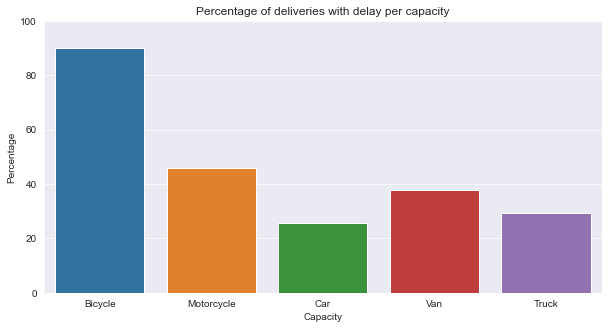

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='vehicle_type', y='percentage', data=df_per_capacity, ax=ax)
ax.set_title('Percentage of deliveries with delay per capacity')
ax.set_xlabel('Capacity')
ax.set_ylabel('Percentage')
ax.set_ylim(0, 100)
